In [49]:
import numpy as np
import pandas as pd
import utilities

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split

from pandas.tools.plotting import scatter_matrix
import random

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

In [50]:
df = pd.read_csv('csv/combined.csv')

    The combined.csv file represents the train and store datasets joined by store ID. The categorical predictor store type is broken out into 4 binary categories

In [51]:
print(df.columns)

Index(['Unnamed: 0', 'Store', 'DayOfWeek', 'Date', 'Sales', 'Customers',
       'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType',
       'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'StoreType_a', 'StoreType_b',
       'StoreType_c', 'StoreType_d'],
      dtype='object')


    To get a sense of the distribution of the data, we can create a simple scatter matrix from a random sampling of the data, looking at our quantitative predictors.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc67c2f3ba8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fc67c06c1d0>]], dtype=object)

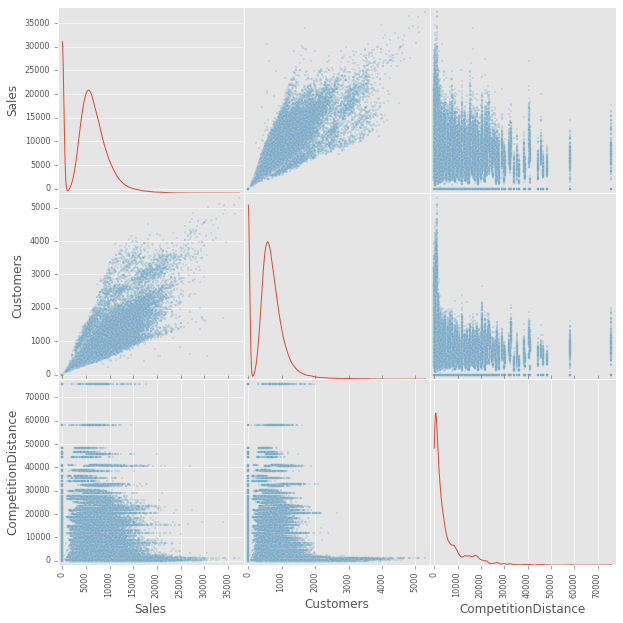

In [61]:
#Requires lots of CPU cycles to generate this scatter_matrix, keep the sample size small
sample_size = int(df['Sales'].size / 5)
sample = df.sample(sample_size)

matplotlib.style.use('ggplot')
scatter_matrix(sample1, alpha=0.2, figsize=(10,10), diagonal='kde')

    We can also examine the distribution of our categorical predictors.

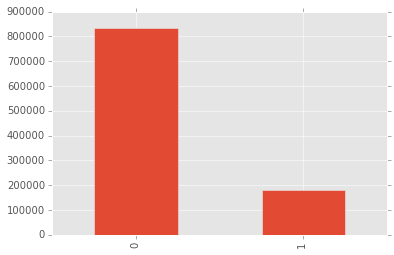

In [58]:
df['SchoolHoliday'].value_counts().plot(kind='bar')

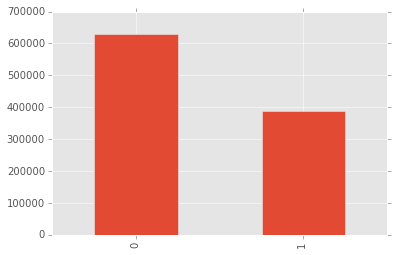

In [57]:
df['Promo'].value_counts().plot(kind='bar')

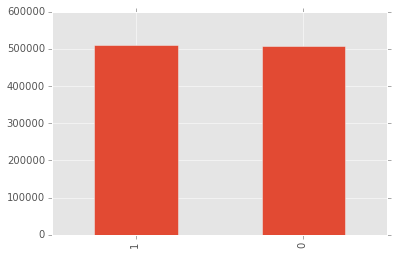

In [59]:
df['Promo2'].value_counts().plot(kind='bar')

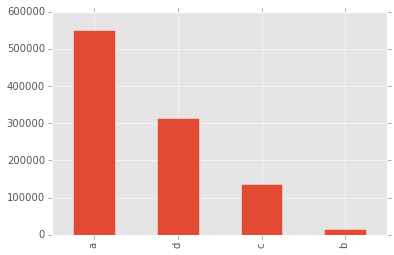

In [60]:
df['StoreType'].value_counts().plot(kind='bar')

In [63]:
def createUnivariateRegression(X_train, y_train):
    estimate = LinearRegression()
    return estimate.fit(X_train, y_train)

def plot(estimate, response, responseLabel, predictor, predictorLabel):
    predictions = estimate.predict(predictor)
    plt.scatter(predictor, response, alpha=0.3)
    plt.xlabel(predictorLabel)
    plt.ylabel(responseLabel)
    plt.plot(predictor, predictions, 'r', alpha=0.9)
    
def splitUnivariateTrainTest(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, random_state=1)
    
    #Convert train and test sets into multidimensional versions of themselves 
    X_train = X_train[:, None]
    y_train = y_train[:, None]
    X_test = X_test[:, None]
    y_test = y_test[:, None]
    
    return X_train, X_test, y_train, y_test


    First we'll take the naive approach of fitting a univariate linear regression to the data, considering only
    the competitor's distance as a predictor. We'll do this by splitting the dataset into one for training the model and one for testing it.

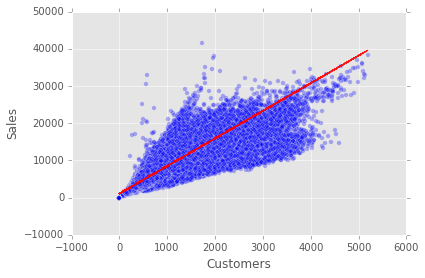

In [64]:
y = df.Sales
X = df.Customers

X_train, X_test, y_train, y_test = splitUnivariateTrainTest(X, y)
customersRegression = createUnivariateRegression(X_train, y_train)
plot(customersRegression, y_test, 'Sales', X_test, 'Customers')

    An R-squared statistic of ~0.8 indicates that the model accounts for most of the variability in the response.

In [65]:
customersRegression.score(X_test, y_test)

0.8007755300735554

    Next we can perform a multivariate linear regression to include each of our predictors when modeling the data.

In [69]:
#Dropping stores without competition from consideration
with_competition = df[np.isfinite(df['CompetitionDistance'])]
X = with_competition[['CompetitionDistance', 'Customers', 'StoreType_a', 'StoreType_b', 'StoreType_c', 'StoreType_d', 'Promo', 'Promo2', 'SchoolHoliday']]
y = with_competition.Sales

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, random_state=1)

est = sm.OLS(y_train, X_train)
est = est.fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.887
Method:                 Least Squares   F-statistic:                 4.968e+05
Date:                Mon, 23 Nov 2015   Prob (F-statistic):               0.00
Time:                        12:14:38   Log-Likelihood:            -4.3556e+06
No. Observations:              507283   AIC:                         8.711e+06
Df Residuals:                  507274   BIC:                         8.711e+06
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
CompetitionDistance     0.0260      0.000    107.137      0.000         0.026     0.027
Customers               7.9006      0.005   1709.604      0.000         7.892     7.910
StoreType_a          -208.7861      4.703    -44.393      0.000      -218.004  -199.568
StoreType_b         -6236.5685     17.172   -363.184      0.000     -6270.225 -6202.912
StoreType_c          -296.7500      6.348    -46.745      0.000      -309.192  -284.308
StoreType_d           867.4405      5.173    167.695      0.000       857.302   877.579
Promo                1191.5882      4.001    297.837      0.000      1183.747  1199.430
Promo2                287.5907      3.749     76.711      0.000       280.243   294.939
SchoolHoliday          75.7559      4.771     15.879      0.000        66.405    85.106
==============================================================================
Omnibus:                   103484.274   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1845216.703
Skew:                           0.503   Prob(JB):                         0.00
Kurtosis:                      12.289   Cond. No.                     9.06e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.06e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The p-values for each of our predictors are low enough to reject the null hypothesis for each.
Each of the coefficients for our categorical variables have standard error measures between 4 and 6.4, except for
StoreType_b. Should we return to linear regression in this study, it could be fruitful to understand why that might be.

Next we can examine a multiple regression with interaction terms.

We build one estimator from the Customers, CompetitionDistance, StoreType_a, and Promo features, as well as their
combination of interaction terms. We'll arbitrarily choose StoreType_a and Promo from among our possible binary classifiers.



In [70]:
interaction_formula = 'Sales ~ Customers * CompetitionDistance * StoreType_a * Promo'
est = sm.OLS.from_formula(interaction_formula, with_competition).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.866
Model:                            OLS   Adj. R-squared:                  0.866
Method:                 Least Squares   F-statistic:                 4.378e+05
Date:                Mon, 23 Nov 2015   Prob (F-statistic):               0.00
Time:                        12:16:23   Log-Likelihood:            -8.7957e+06
No. Observations:             1014567   AIC:                         1.759e+07
Df Residuals:                 1014551   BIC:                         1.759e+07
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
===================================================================================================================
                                                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------------------------------
Intercept                                        1430.3176      5.047    283.422      0.000      1420.426  1440.209
Customers                                           5.6693      0.007    849.179      0.000         5.656     5.682
CompetitionDistance                                -0.0910      0.001   -137.022      0.000        -0.092    -0.090
Customers:CompetitionDistance                       0.0003   1.19e-06    254.901      0.000         0.000     0.000
StoreType_a                                     -1080.7962      6.691   -161.538      0.000     -1093.910 -1067.683
Customers:StoreType_a                               1.6662      0.009    185.299      0.000         1.649     1.684
CompetitionDistance:StoreType_a                     0.0818      0.001     99.971      0.000         0.080     0.083
Customers:CompetitionDistance:StoreType_a          -0.0003   1.39e-06   -182.183      0.000        -0.000    -0.000
Promo                                            2541.7312     10.127    250.987      0.000      2521.883  2561.580
Customers:Promo                                    -0.8919      0.011    -78.005      0.000        -0.914    -0.870
CompetitionDistance:Promo                          -0.1616      0.002   -101.470      0.000        -0.165    -0.158
Customers:CompetitionDistance:Promo                 0.0001   2.29e-06     64.212      0.000         0.000     0.000
StoreType_a:Promo                               -1731.2553     13.770   -125.723      0.000     -1758.245 -1704.266
Customers:StoreType_a:Promo                         1.3147      0.015     85.883      0.000         1.285     1.345
CompetitionDistance:StoreType_a:Promo               0.1312      0.002     68.449      0.000         0.127     0.135
Customers:CompetitionDistance:StoreType_a:Promo    -0.0001   2.62e-06    -41.835      0.000        -0.000    -0.000
==============================================================================
Omnibus:                   170137.122   Durbin-Watson:                   0.874
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2901934.677
Skew:                           0.282   Prob(JB):                         0.00
Kurtosis:                      11.266   Cond. No.                     1.11e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.11e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""